In [1]:
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LatitudeFormatter, LongitudeFormatter
import dask
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr
import xcdat as xc
from scipy.stats import ttest_ind
from sofia_project.util import cleanocn
from xesmf import Regridder

dask.config.set(scheduler="single-threaded")

mpl.rcParams["figure.figsize"] = 6, 4
mpl.rcParams["font.size"] = 12

### Load data to make annual means plot

In [2]:
droot = Path("../data/processed/HadGEM3-GC31-LL")

expts = ["historical", "ssp585"]

variables = ["tas", "tos", "zos", "uos", "vos"]

expdict = {"historical": "hist-antwater-92-11", "ssp585": "ssp585-ismip6-water"}

In [3]:
ddict = {}

for exp in expts:
    print(exp)
    ddict[exp] = {}

    for var in variables:
        print(f"\t{var}")
        
        if var in ["tos", "zos", "uos", "vos"]:
            realm = "Omon"
        else:
            realm = "Amon"

        ddir = droot.joinpath(expdict[exp], realm, var)

        nce = list(ddir.glob(f"{var}_*_{expdict[exp]}_ens*.nc"))[0]
        dse = xr.open_dataset(nce)

        if exp == "historical":
            
            hdir = droot.joinpath("historical", realm, var)
            sdir = droot.joinpath("ssp245", realm, var)
            
            nch = list(hdir.glob(f"{var}_*_historical_ens*.nc"))[0]
            ncs = list(sdir.glob(f"{var}_*_ssp245_ens*.nc"))[0]

            dsh = xr.open_dataset(nch).sel(time=slice("1992-01", "2014-12"))
            dss = xr.open_dataset(ncs).sel(time=slice("2015-01", "2020-12"))

            dsc = xr.concat((dsh, dss), "time")

        else:
            cdir = droot.joinpath(exp, realm, var)
            ncc = list(cdir.glob(f"{var}_*_{exp}_ens*.nc"))[0]

            dsc = xr.open_dataset(ncc)

        if var in ["tos", "zos", "uos", "vos"]:
            dsc = cleanocn(dsc)
            dse = cleanocn(dse)
        else:
            dse = dse.rename({"latitude": "lat", "longitude": "lon"})

        dac = dsc[var].squeeze()
        if var in ["tos", "zos", "uos", "vos"]:
            dae = dse[var].isel(i=slice(1, -1), j=slice(1, -1)).squeeze()
        else:
            dae = dse[var]

        ddict[exp][var] = {"ctrl": dac, "expt": dae}

historical
	tas
	tos
	zos
	uos
	vos
ssp585
	tas
	tos
	zos
	uos
	vos


### Compute anomalies and statistical significance

In [4]:
def stattest2d(ctrl, expt):
    tstat, pval = ttest_ind(ctrl, expt)

    if len(ctrl.lat.dims) == 2:
        xpval = xr.DataArray(
            pval,
            coords={
                "lat": (("j", "i"), ctrl.lat.data),
                "lon": (("j", "i"), ctrl.lon.data),
            },
            dims=["j", "i"],
        )
    else:
        xpval = xr.DataArray(
            pval,
            coords={
                "lat": ("lat", ctrl.lat.data),
                "lon": ("lon", ctrl.lon.data),
            },
            dims=["lat", "lon"],
        )

    tanom = (expt - ctrl).mean("year")

    return xpval, tanom


def rectilinear_regrid(da):
    # Regrid p values to rectilinear grid so that contourf works
    rlat = np.arange(-90, 91)
    rlon = np.arange(-180, 181)

    dsout = xr.DataArray(
        np.zeros((rlat.size, rlon.size)),
        dims=["j", "i"],
        coords={"lat": ("j", rlat), "lon": ("i", rlon)},
    )

    regridder = Regridder(da, dsout, method="bilinear")
    da_r = regridder(da)

    return da_r

In [5]:
yrdict = {
    "historical": {"yr1": "2011", "yr2": "2020"},
    "ssp585": {"yr1": "2071", "yr2": "2100"},
}

In [6]:
anomdict = {}
pvaldict = {}

for exp in expts:
    print(exp)
    tspan = slice(f"{yrdict[exp]['yr1']}-01", f"{yrdict[exp]['yr2']}-12")

    anomdict[exp] = {}
    pvaldict[exp] = {}

    for var in variables:
        print(f"\t{var}")
        dac_an = (
            ddict[exp][var]["ctrl"]
            .sel(time=tspan)
            .groupby("time.year")
            .mean(("time"))
            .compute()
        )
        dasof_an = (
            ddict[exp][var]["expt"]
            .sel(time=tspan)
            .groupby("time.year")
            .mean(("time"))
            .compute()
        )

        pval, anom = stattest2d(dac_an, dasof_an)

        if var in ["tos", "zos"]:
            pval = rectilinear_regrid(pval)

        anomdict[exp][var] = anom
        pvaldict[exp][var] = pval

historical
	tas
	tos


/scale_wlg_persistent/filesets/project/uoo03538/andrew.pauling/condaenvs/sofia_project/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


	zos


/scale_wlg_persistent/filesets/project/uoo03538/andrew.pauling/condaenvs/sofia_project/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


	uos
	vos
ssp585
	tas
	tos


/scale_wlg_persistent/filesets/project/uoo03538/andrew.pauling/condaenvs/sofia_project/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


	zos


/scale_wlg_persistent/filesets/project/uoo03538/andrew.pauling/condaenvs/sofia_project/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


	uos
	vos


### Make plot

In [7]:
labeldict = {"tas": "$\Delta$T [K]", "tos": "$\Delta$SST [K]", "zos": "$\Delta$SSH [m]"}
titledict = {"tas": "2 m air temperature", "tos": "SST", "zos": "SSH"}
cmapdict = {"tas": "RdBu_r", "tos": "RdBu_r", "zos": "PuOr"}
climdict = {"tas": 0.5, "tos": 0.5, "zos": 0.05}

letters = np.array([["a", "b", "c", "d"], ["e", "f", "g", "h"]])

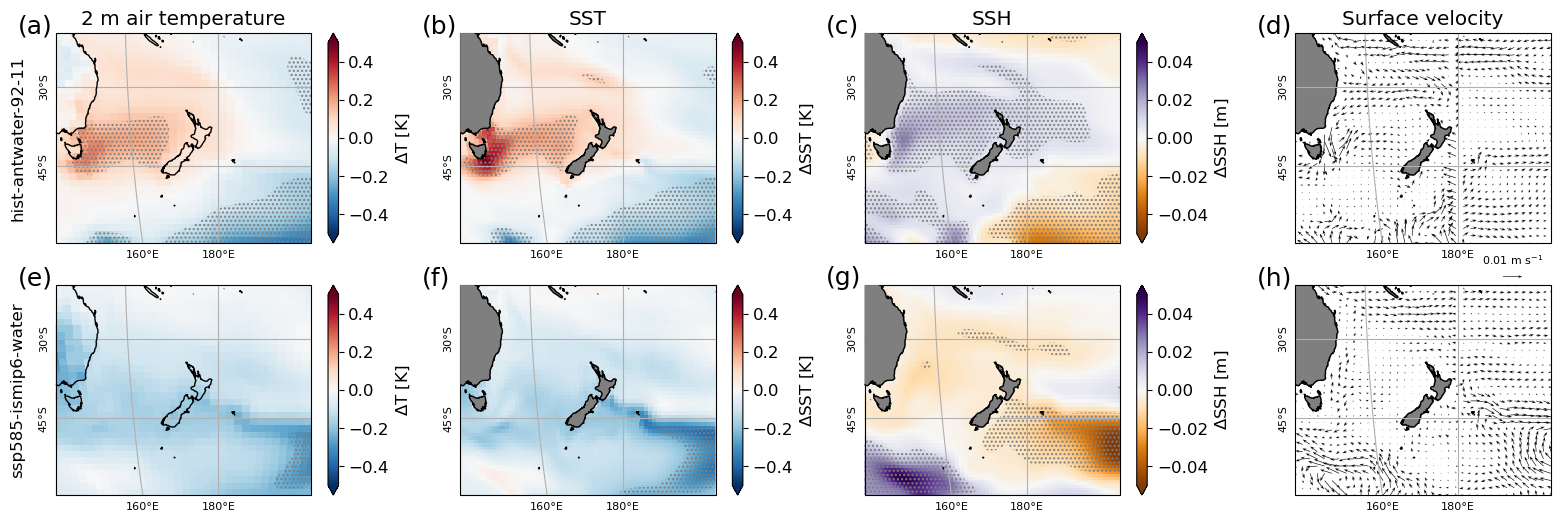

In [8]:
fig, axs = plt.subplots(
    2,
    4,
    figsize=(20, 6),
    subplot_kw={"projection": ccrs.Robinson(central_longitude=180)},
)



for e, exp in enumerate(expts):
    for n, var in enumerate(variables[:3]):
        if var in ["tos", "zos"]:
            axs[e, n].add_feature(cfeature.LAND, color="tab:gray", zorder=100)
        axs[e, n].coastlines(zorder=101)
        gl = axs[e, n].gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
        gl.xlocator = mticker.FixedLocator([160, 180])
        gl.ylocator = mticker.FixedLocator([-45, -30, -15])
        gl.top_labels = False
        gl.bottom_labels = True
        gl.left_labels = True
        gl.xformatter = LongitudeFormatter(dateline_direction_label=True)
        gl.xlabel_style = {'size': 8, 'color': 'k'}
        gl.ylabel_style = {'size': 8, 'color': 'k', 'rotation': 90}

        axs[e, n].set_extent([145, 200, -60, -20], crs=ccrs.PlateCarree())
        im = anomdict[exp][var].plot.pcolormesh(
            "lon",
            "lat",
            ax=axs[e, n],
            transform=ccrs.PlateCarree(),
            cbar_kwargs={"label": labeldict[var], "extend": "both"},
            cmap=cmapdict[var],
        )
        im.set_clim(-climdict[var], climdict[var])

        levels = [0, 0.05, 0.1, 1]
        cs = pvaldict[exp][var].plot.contourf(
            "lon",
            "lat",
            ax=axs[e, n],
            transform=ccrs.PlateCarree(),
            levels=levels,
            hatches=["....", "", ""],
            colors="none",
            add_colorbar=False,
        )

        cs.set_edgecolor("tab:gray")
        cs.set_linewidth(0.0)

        if e == 0:
            axs[e, n].set_title(titledict[var])
        else:
            axs[e, n].set_title("")
            
        axs[e, n].annotate(f"({letters[e, n]})", xy=(-0.15, 1.0), xycoords="axes fraction", fontsize=18)
        

u = anomdict["historical"]["uos"]
v = anomdict["historical"]["vos"]
regridder = Regridder(v, u, method="bilinear")
vplt = regridder(v)

axs[0, 3].coastlines()
axs[0, 3].set_extent([145, 200, -60, -20], crs=ccrs.PlateCarree())
axs[0, 3].add_feature(cfeature.LAND, color="tab:gray")
gl = axs[0, 3].gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlocator = mticker.FixedLocator([160, 180])
gl.ylocator = mticker.FixedLocator([-45, -30, -15])
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.xformatter = LongitudeFormatter(dateline_direction_label=True)
gl.xlabel_style = {'size': 8, 'color': 'k'}
gl.ylabel_style = {'size': 8, 'color': 'k', 'rotation': 90}
q = axs[0, 3].quiver(u.lon, u.lat, u, v, transform=ccrs.PlateCarree(), regrid_shape=30, headwidth=5, headlength=7)
axs[0, 3].set_title("Surface velocity")
axs[0, 3].annotate(f"(d)", xy=(-0.15, 1.0), xycoords="axes fraction", fontsize=18)


u = anomdict["ssp585"]["uos"]
v = anomdict["ssp585"]["vos"]
regridder = Regridder(v, u, method="bilinear")
vplt = regridder(v)

axs[1, 3].coastlines()
axs[1, 3].set_extent([145, 200, -60, -20], crs=ccrs.PlateCarree())
axs[1, 3].add_feature(cfeature.LAND, color="tab:gray")
gl = axs[1, 3].gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlocator = mticker.FixedLocator([160, 180])
gl.ylocator = mticker.FixedLocator([-45, -30, -15])
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.xformatter = LongitudeFormatter(dateline_direction_label=True)
gl.xlabel_style = {'size': 8, 'color': 'k'}
gl.ylabel_style = {'size': 8, 'color': 'k', 'rotation': 90}
q = axs[1, 3].quiver(u.lon, u.lat, u, v, transform=ccrs.PlateCarree(), regrid_shape=30, headwidth=5, headlength=7)
axs[1, 3].quiverkey(q, 0.85, 1.04, 0.01, label="0.01 m s$^{-1}$", coordinates="axes", fontproperties={"size": 8})
axs[1, 3].annotate(f"(h)", xy=(-0.15, 1.0), xycoords="axes fraction", fontsize=18)


axs[0, 0].annotate(
    "hist-antwater-92-11",
    xy=(-0.15, 0.5),
    xycoords="axes fraction",
    rotation=90,
    ha="center",
    va="center",
)
axs[1, 0].annotate(
    "ssp585-ismip6-water",
    xy=(-0.15, 0.5),
    xycoords="axes fraction",
    rotation=90,
    ha="center",
    va="center",
)

fig.savefig("../figures/nz_climresponse_annmean_combined_v3.png", bbox_inches="tight", dpi=300)